In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [ ]:
dir = "/content/drive/MyDrive/sampah-plastik.v2"
csv_file= "_annotations.csv"
train_csv_dir = os.path.join(dir, 'train', csv_file)
valid_csv_dir = os.path.join(dir, 'valid', csv_file)

In [ ]:
# load train dataframe
with open(train_csv_dir) as train_csv:
  train_annotation_df = pd.read_csv(train_csv, header=0)
# type(train_annotation_df)
train_annotation_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,hdpe_container_7-Background-Removed_png.rf.262...,320,320,HDPE,0,0,320,320
1,1593761617f4ba02d3e4929474ce227b6fb54b784b_23_...,320,320,PP,8,71,302,244
2,1593761617814986295ca42189cab256641df2314d_35_...,320,320,PP,10,19,272,275
3,c7x67h_jpeg.rf.2592ff0666daa28bec197590d29be54...,320,320,PVC,198,14,319,209
4,2d9k0ka_jpeg.rf.245f8e8b0331d6f1527130799e5d95...,320,320,HDPE,11,0,320,265


In [ ]:
# load valid dataframe
with open(valid_csv_dir) as valid_csv:
  valid_annotation_df = pd.read_csv(valid_csv, header=0)
# type(valid_annotation_df)
valid_annotation_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,pet_53-Background-Removed_png.rf.0731a23db2c55...,320,320,PET,73,0,227,309
1,plastic469_jpg.rf.0506d99bd3b0a7953d5a617e6a29...,320,320,PET,0,68,191,300
2,a73208dab172110f139382b99119fbe5_jpeg.rf.03ff1...,320,320,PP,30,76,293,233
3,plastic230_jpg.rf.04e91559bc2b0daf7fe3ed1214e5...,320,320,PET,26,95,249,240
4,pp_25-Background-Removed_png.rf.03fb5e7c2651dd...,320,320,PP,35,122,293,252


# Convert class from str to int

In [ ]:
class_dict = {
        'HDPE' : 0,
        'LDPE' : 1,
        'PVC' : 2,
        'PP' : 3,
        'PET' : 4,
        'PS' : 5,
        'Other' : 6
}

def indexing_class(dataframe):
    # We need to convert class name to int index
    return dataframe.replace({'class' : class_dict})

In [ ]:
# Indexing train
train_annotation_df = indexing_class(train_annotation_df)
train_annotation_df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,hdpe_container_7-Background-Removed_png.rf.262...,320,320,0,0,0,320,320
1,1593761617f4ba02d3e4929474ce227b6fb54b784b_23_...,320,320,3,8,71,302,244
2,1593761617814986295ca42189cab256641df2314d_35_...,320,320,3,10,19,272,275
3,c7x67h_jpeg.rf.2592ff0666daa28bec197590d29be54...,320,320,2,198,14,319,209
4,2d9k0ka_jpeg.rf.245f8e8b0331d6f1527130799e5d95...,320,320,0,11,0,320,265
...,...,...,...,...,...,...,...,...
3560,17600_1639553680-Background-Removed-0991_9_11z...,320,320,3,21,96,305,241
3561,pigeon_pp_rp_botol_susu_bayi_motif_badak_120_m...,320,320,3,103,0,230,257
3562,hdpe_container_33-Background-Removed_png.rf.f3...,320,320,0,2,2,273,320
3563,adasd_36_11zon-Background-Removed_png.rf.f3125...,320,320,3,0,52,318,268


In [ ]:
# Indexing valid
valid_annotation_df = indexing_class(valid_annotation_df)
valid_annotation_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,pet_53-Background-Removed_png.rf.0731a23db2c55...,320,320,4,73,0,227,309
1,plastic469_jpg.rf.0506d99bd3b0a7953d5a617e6a29...,320,320,4,0,68,191,300
2,a73208dab172110f139382b99119fbe5_jpeg.rf.03ff1...,320,320,3,30,76,293,233
3,plastic230_jpg.rf.04e91559bc2b0daf7fe3ed1214e5...,320,320,4,26,95,249,240
4,pp_25-Background-Removed_png.rf.03fb5e7c2651dd...,320,320,3,35,122,293,252


# Show Bounding Box

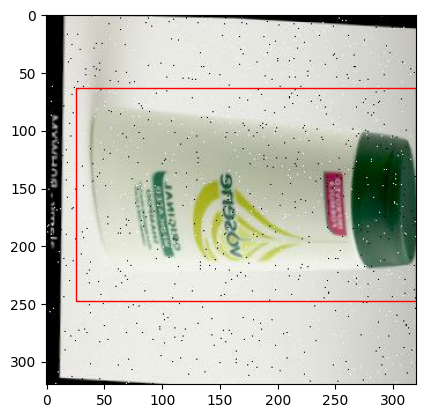

In [ ]:
# Function to load image and its annotations
def load_image_and_annotations(filename, img_dir, annotations):
    img_path = os.path.join(img_dir, filename)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, [320, 320])

    # Get the annotations for the current image
    image_annotations = annotations[annotations['filename'] == filename]
    boxes = image_annotations[['xmin', 'ymin', 'xmax', 'ymax']].values
    classes = image_annotations['class'].values

    # one hot
    one_hot_classes = tf.one_hot(classes, depth=7)

    # # Normalize bounding box coordinates
    # img_height, img_width, _ = img.shape
    # boxes = boxes / [img_width, img_height, img_width, img_height]

    return img, boxes, one_hot_classes

# Load a sample image and annotations for testing
sample_filename = train_annotation_df['filename'].iloc[667]
train_images_path = os.path.join(dir, 'train')
img, boxes, classes = load_image_and_annotations(filename=sample_filename,
                                                 img_dir=train_images_path,
                                                 annotations=train_annotation_df)

# Display image and annotations for verification

fig, ax = plt.subplots(1)
ax.imshow(img.numpy().astype("uint8"))

for box in boxes:
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)


plt.show()

# Create Tensorflow Dataset
## Using tf.data.Dataset.from_generator()
The generator argument must be a callable object that returns an object that supports the `iter()` protocol (e.g. a generator function).

The elements generated by generator must be compatible with either the given `output_signature` argument or with the given `output_types` and (optionally) `output_shapes` arguments, whichever was specified.

The recommended way to call `from_generator` is to use the `output_signature` argument. In this case the output will be assumed to consist of objects with the classes, shapes and types defined by `tf.TypeSpec` objects from `output_signature` argument

In [ ]:
# # DON'T RUN THIS CODE
# # Just example from "https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_generator"

# def gen():
#   ragged_tensor = tf.ragged.constant([[1, 2], [3]])
#   yield 42, ragged_tensor

# dataset = tf.data.Dataset.from_generator(
#      gen,
#      output_signature=(
#          tf.TensorSpec(shape=(), dtype=tf.int32),
#          tf.RaggedTensorSpec(shape=(2, None), dtype=tf.int32)))

# list(dataset.take(1))

In [ ]:
# Create Train Dataset

train_filenames = train_annotation_df['filename'].unique()
train_images_path = os.path.join(dir, 'train')

def train_generator():
  for filename in train_filenames:
    img, boxes, classes = load_image_and_annotations(filename=filename,
                                                 img_dir=train_images_path,
                                                 annotations=train_annotation_df)

    yield img, boxes, classes

train_dataset = tf.data.Dataset.from_generator(
                    train_generator,
                    output_signature=(
                        # Shape of img (width, height, color)
                        tf.TensorSpec(shape=(320, 320, 3), dtype=tf.float32),

                        # Shape of boxes (None, (xmin, ymin, xmax, ymax))
                        tf.TensorSpec(shape=(None, 4), dtype=tf.float32),

                        # Shape of classes
                        tf.TensorSpec(shape=(None, 7), dtype=tf.float32),
                    )
                )



train_dataset.take(5)

<_TakeDataset element_spec=(TensorSpec(shape=(320, 320, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

#Validation Dataframe

In [ ]:
# Create Validation Dataset

valid_filenames = valid_annotation_df['filename'].unique()
valid_images_path = os.path.join(dir, 'valid')

def valid_generator():
  for filename in valid_filenames:
    img, boxes, classes = load_image_and_annotations(filename=filename,
                                                 img_dir=valid_images_path,
                                                 annotations=valid_annotation_df)
    yield img, boxes, classes


valid_dataset = tf.data.Dataset.from_generator(
                    valid_generator,
                    output_signature=(
                        # Shape of img (width, height, color)
                        tf.TensorSpec(shape=(320, 320, 3), dtype=tf.float32),

                        # Shape of box (None, (xmin, ymin, xmax, ymax))
                        tf.TensorSpec(shape=(None, 4), dtype=tf.float32),

                        # Shape of classes
                        tf.TensorSpec(shape=(None, 7), dtype=tf.float32),
                    )
                )
valid_dataset.take(5)

<_TakeDataset element_spec=(TensorSpec(shape=(320, 320, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

In [ ]:
# Batch dataset
batch_size = 1
train_dataset = train_dataset.batch(batch_size)
valid_dataset = valid_dataset.batch(batch_size)

# Preprocess Data
We need to adjust the input pipeline. `TF Object Detection` API need specified format.
https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py

In [23]:
def preprocess_data(img, boxes, classes):
    # # We don't need to normalize images
    # # Normalize images to the range [0, 1]
    # img = img / 255.0
    classes = tf.squeeze(classes, [0, 1])
    classes = tf.reshape(classes, (1, 7))
    return img, {'bbox': boxes, 'class_id': classes}

In [ ]:
# Preprocess train_dataset
train_dataset = train_dataset.map(preprocess_data)

# Preprocess valid_dataset
valid_dataset = valid_dataset.map(preprocess_data)

# Read this

We can use pre-trained model for object detection. We use this as base model: https://keras.io/api/applications/efficientnet/

Use argument `weights='imagenet'`



```
# Use this as top model in functional API
base_model = EfficientNetB0(input_shape=(320, 320, 3),
              include_top=False,
              weights='imagenet')

```





In [ ]:
from tensorflow.keras.applications import EfficientNetB0

# Load the pre-trained model
base_model = EfficientNetB0(input_shape=(320, 320, 3),
              include_top=False,
              weights='imagenet')

# Freeze base_model
base_model.trainable = False

16705208/16705208 [==============================] - 2s 0us/step


# Create Model
Since we have 2 outputs such as class and bounding box, we use functional API to build the model.

In [ ]:
input_layer = tf.keras.Input(shape=(320, 320, 3))

# Hidden layer
x = base_model(input_layer, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)

# Bounding box output (xmin, ymin, xmax, ymax)
bbox_outputs = tf.keras.layers.Dense(4, activation='linear', name='bbox')(x)

# Class name output
class_outputs = tf.keras.layers.Dense(7, activation='softmax', name='class_id')(x)

model = tf.keras.Model(inputs=input_layer, outputs=[bbox_outputs, class_outputs])

# model.summary()

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss={
                  'bbox': 'mse',
                  'class_id': 'categorical_crossentropy'
                  },
              metrics={'class_id': 'accuracy'},
              run_eagerly=True)

In [ ]:
# Train the model
model.fit(train_dataset,
          epochs=10,
          steps_per_epoch=100,
          validation_data=valid_dataset)

Epoch 1/10


 34/100 [=========>....................] - ETA: 50s - loss: 19272.4941 - bbox_loss: 19260.7637 - class_id_loss: 11.7283 - class_id_accuracy: 0.3235

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} Can not squeeze dim[1], expected a dimension of 1, got 2
	 [[{{node Squeeze}}]] [Op:IteratorGetNext] name: 